In [1]:
import numpy as np
import itertools
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

# ANFIS Implementation

In [2]:
class MembershipFunction:
    """
    Gaussian membership function:
       μ(x; c, σ) = exp(-0.5 * ((x - c)/σ)^2)
    """
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

    def evaluate(self, x):
        return np.exp(-0.5 * ((x - self.mean) / self.sigma) ** 2)

    def update_parameters(self, d_mean, d_sigma, lr):
        self.mean -= lr * d_mean
        self.sigma -= lr * d_sigma

In [3]:
class ANFIS:
    def __init__(self, n_inputs, n_mfs):
        """
        n_inputs: number of input features.
        n_mfs: number of membership functions per input.
        """
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        
        # Initialize membership functions for each input.
        self.mfs = []
        for i in range(n_inputs):
            mfs_for_input = [MembershipFunction(mean=np.random.uniform(0, 1),
                                                sigma=np.random.uniform(0.1, 1))
                             for _ in range(n_mfs)]
            self.mfs.append(mfs_for_input)
        
        # Create rule base: each rule is a combination of one membership function per input.
        self.rules = list(itertools.product(range(n_mfs), repeat=n_inputs))
        self.n_rules = len(self.rules)
        
        # Initialize consequent parameters for each rule.
        # Each consequent is a linear function: f = p1*x1 + p2*x2 + ... + pn*xn + r.
        self.consequents = np.random.rand(self.n_rules, n_inputs + 1)

    def forward(self, X):
        n_samples = X.shape[0]
        
        # Layer 1: Evaluate membership functions.
        mf_outputs = []
        for i in range(self.n_inputs):
            x = X[:, i]
            outputs = np.zeros((n_samples, self.n_mfs))
            for j in range(self.n_mfs):
                outputs[:, j] = self.mfs[i][j].evaluate(x)
            mf_outputs.append(outputs)
        
        # Layer 2: Compute firing strengths for each rule.
        firing_strengths = np.zeros((n_samples, self.n_rules))
        for r, rule in enumerate(self.rules):
            prod = np.ones(n_samples)
            for i, mf_index in enumerate(rule):
                prod *= mf_outputs[i][:, mf_index]
            firing_strengths[:, r] = prod
        
        # Layer 3: Normalize the firing strengths.
        sum_fs = np.sum(firing_strengths, axis=1, keepdims=True)
        normalized_fs = firing_strengths / (sum_fs + 1e-6)
        
        # Layer 4: Compute each rule's output.
        # Augment input with a bias term.
        X_aug = np.hstack((X, np.ones((n_samples, 1))))
        rule_outputs = np.zeros((n_samples, self.n_rules))
        for r in range(self.n_rules):
            params = self.consequents[r]
            rule_outputs[:, r] = np.dot(X, params[:-1]) + params[-1]
        
        # Layer 5: Aggregate rule outputs weighted by normalized firing strengths.
        output = np.sum(normalized_fs * rule_outputs, axis=1)
        return output, firing_strengths, normalized_fs, rule_outputs

    def train(self, X, y, epochs=50, lr=0.01):
        n_samples = X.shape[0]
        for epoch in range(epochs):
            output, firing_strengths, normalized_fs, rule_outputs = self.forward(X)
            
            # Compute error and mean squared error (MSE).
            error = y - output
            mse = np.mean(error ** 2)
            print(f"ANFIS Epoch {epoch+1}/{epochs}, MSE: {mse:.4f}")
            
            # Update consequent parameters using gradient descent.
            for r in range(self.n_rules):
                grad = -2 * normalized_fs[:, r][:, None] * error[:, None] * np.hstack((X, np.ones((n_samples, 1))))
                grad_mean = np.mean(grad, axis=0)
                self.consequents[r] -= lr * grad_mean
            
            # (Premise parameters update is not implemented here.)
        print("ANFIS training complete.")

    def predict(self, X):
        output, *_ = self.forward(X)
        return output


# Data Preparation

In [4]:
# Load California Housing dataset.
data = fetch_california_housing()
X = data.data      # Features shape: (n_samples, 8)
y = data.target    # Targets shape: (n_samples,)

# Scale features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Train ANFIS Model

In [5]:
anfis_model = ANFIS(n_inputs=X_train.shape[1], n_mfs=3)
anfis_model.train(X_train, y_train, epochs=50, lr=0.01)

# Evaluate ANFIS.
y_train_pred_anfis = anfis_model.predict(X_train)
y_test_pred_anfis = anfis_model.predict(X_test)
train_mse_anfis = np.mean((y_train - y_train_pred_anfis) ** 2)
test_mse_anfis = np.mean((y_test - y_test_pred_anfis) ** 2)
print(f"\nANFIS - Training MSE: {train_mse_anfis:.4f}")
print(f"ANFIS - Testing MSE: {test_mse_anfis:.4f}")

# -------------------------------
# Train Simple Neural Network
# -------------------------------

# Create a simple neural network with one hidden layer of 50 neurons.
mlp = MLPRegressor(hidden_layer_sizes=(50,), activation='relu',
                   solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Evaluate Neural Network.
y_train_pred_nn = mlp.predict(X_train)
y_test_pred_nn = mlp.predict(X_test)
train_mse_nn = np.mean((y_train - y_train_pred_nn) ** 2)
test_mse_nn = np.mean((y_test - y_test_pred_nn) ** 2)
print(f"\nNeural Network - Training MSE: {train_mse_nn:.4f}")
print(f"Neural Network - Testing MSE: {test_mse_nn:.4f}")

ANFIS Epoch 1/50, MSE: 4.0628
ANFIS Epoch 2/50, MSE: 4.0622
ANFIS Epoch 3/50, MSE: 4.0616
ANFIS Epoch 4/50, MSE: 4.0610
ANFIS Epoch 5/50, MSE: 4.0604
ANFIS Epoch 6/50, MSE: 4.0598
ANFIS Epoch 7/50, MSE: 4.0593
ANFIS Epoch 8/50, MSE: 4.0587
ANFIS Epoch 9/50, MSE: 4.0581
ANFIS Epoch 10/50, MSE: 4.0575
ANFIS Epoch 11/50, MSE: 4.0569
ANFIS Epoch 12/50, MSE: 4.0563
ANFIS Epoch 13/50, MSE: 4.0558
ANFIS Epoch 14/50, MSE: 4.0552
ANFIS Epoch 15/50, MSE: 4.0546
ANFIS Epoch 16/50, MSE: 4.0540
ANFIS Epoch 17/50, MSE: 4.0534
ANFIS Epoch 18/50, MSE: 4.0528
ANFIS Epoch 19/50, MSE: 4.0523
ANFIS Epoch 20/50, MSE: 4.0517
ANFIS Epoch 21/50, MSE: 4.0511
ANFIS Epoch 22/50, MSE: 4.0505
ANFIS Epoch 23/50, MSE: 4.0499
ANFIS Epoch 24/50, MSE: 4.0494
ANFIS Epoch 25/50, MSE: 4.0488
ANFIS Epoch 26/50, MSE: 4.0482
ANFIS Epoch 27/50, MSE: 4.0476
ANFIS Epoch 28/50, MSE: 4.0470
ANFIS Epoch 29/50, MSE: 4.0464
ANFIS Epoch 30/50, MSE: 4.0459
ANFIS Epoch 31/50, MSE: 4.0453
ANFIS Epoch 32/50, MSE: 4.0447
ANFIS Epoch 33/50

# Plot Predictions Comparison

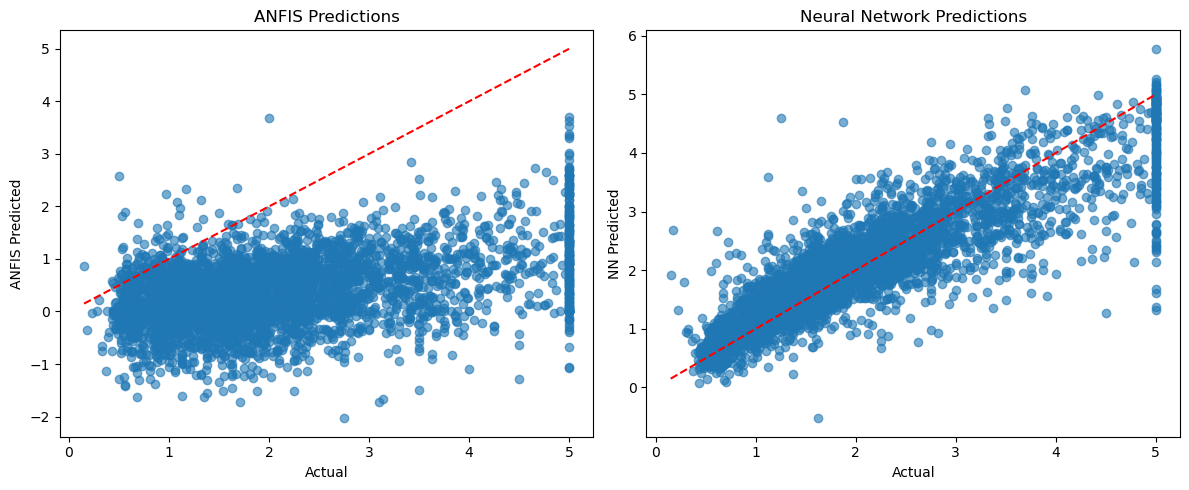

In [7]:
plt.figure(figsize=(12, 5))

# ANFIS predictions plot.
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_anfis, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("ANFIS Predicted")
plt.title("ANFIS Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

# Neural Network predictions plot.
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_nn, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("NN Predicted")
plt.title("Neural Network Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

plt.tight_layout()
plt.show()